# Heart Disease Classification using Neural Networks

This notebook demonstrates the development of a neural network model for predicting heart disease using various health indicators. The model is trained on a comprehensive dataset containing multiple health metrics and lifestyle factors.

## Dataset Overview
The dataset contains 10,000 records with 21 features including:
- Demographic information (Age, Gender)
- Clinical measurements (Blood Pressure, Cholesterol, BMI)
- Medical history (Family Heart Disease, Diabetes)
- Lifestyle factors (Exercise Habits, Smoking, Alcohol Consumption)
- Target variable: Heart Disease Status (Yes/No)

## Project Goals
1. Build a neural network classifier to predict heart disease risk
2. Analyze feature importance and relationships
3. Evaluate model performance across different architectures
4. Optimize model for real-world application

## Libraries and Setup


## Data Loading and Initial Exploration

In this section, we:
1. Import necessary libraries for data processing, visualization, and modeling
2. Load the heart disease dataset
3. Examine basic dataset characteristics including:
   - Dataset dimensions
   - Feature types
   - Missing values
   - Basic statistics


In [16]:
# Import essential libraries for data processing, visualization, and machine learning
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import os

# ============================================================================
# REPRODUCIBILITY SETTINGS FOR TENSORFLOW WITH CUDA
# ============================================================================
# These settings ensure consistent results across runs when using CUDA

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load the heart disease dataset
# Dataset source: https://www.kaggle.com/datasets/oktayrdeki/heart-disease
df = pd.read_csv('Data/heart_disease.csv')


In [17]:
print(f"Dataset Shape {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")
print(f"Dataset Info: {df.info()}")
print(f"First five rows: {df.head()}")
print(f"Missing values: ${df.isnull().sum()}")
print(f"Basic Stats: {df.describe()}")



Dataset Shape (10000, 21)
Total Records: 10,000
Total Features: 21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Slee

## Data Preprocessing

### Feature Engineering and Encoding
1. **Categorical Variable Encoding**:
   - Binary variables (Yes/No) → 1/0
   - Ordinal variables (Low/Medium/High) → 0/1/2
   - Gender (Male/Female) → 1/0

2. **Data Cleaning**:
   - Handling missing values through removal
   - Standardizing numerical features
   
3. **Train-Test Split**:
   - Training set: 60%
   - Cross-validation set: 20%
   - Test set: 20%

This ensures proper evaluation of model performance and prevents data leakage.


In [18]:
#You can use obj_df = df.select_dtypes(include=['object']).copy()
# Guide to refrence for encoding valueshttps://pbpython.com/categorical-encoding.html 

print(df.columns)
categroical_values = []
for colum in df.columns:
    if not(pd.api.types.is_numeric_dtype(df[colum])):
        categroical_values.append(colum)
        
print("Categorical Values:",categroical_values)


Index(['Age', 'Gender', 'Blood Pressure', 'Cholesterol Level',
       'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'BMI',
       'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
       'Alcohol Consumption', 'Stress Level', 'Sleep Hours',
       'Sugar Consumption', 'Triglyceride Level', 'Fasting Blood Sugar',
       'CRP Level', 'Homocysteine Level', 'Heart Disease Status'],
      dtype='object')
Categorical Values: ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption', 'Heart Disease Status']


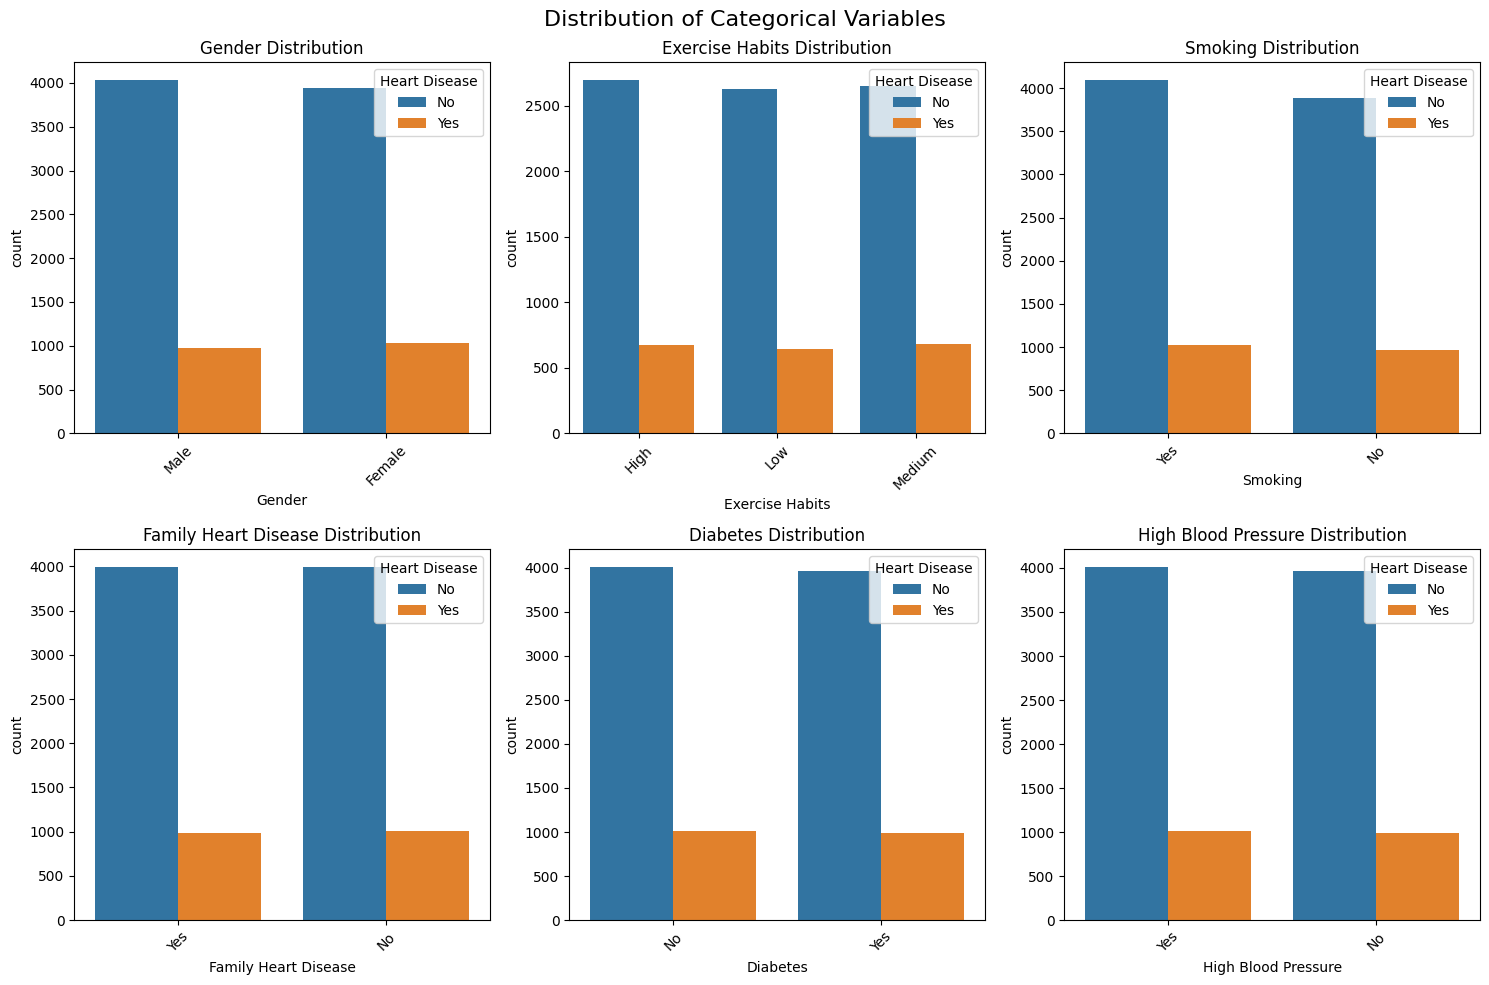

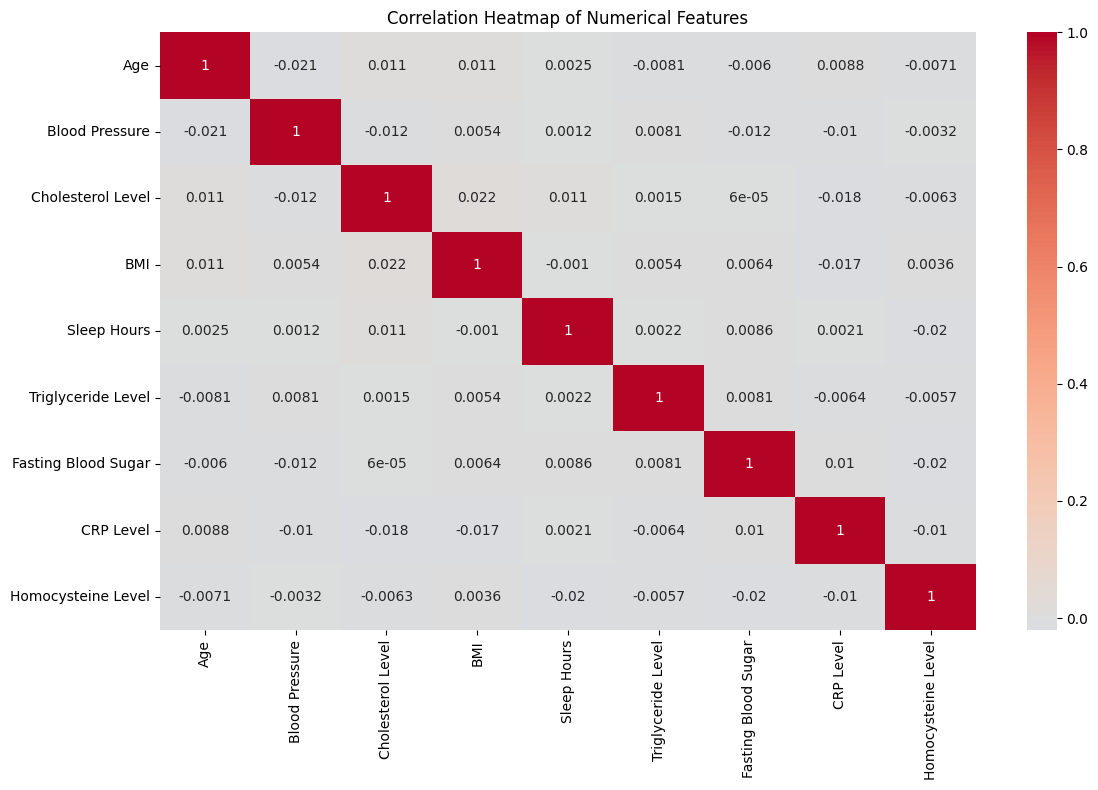

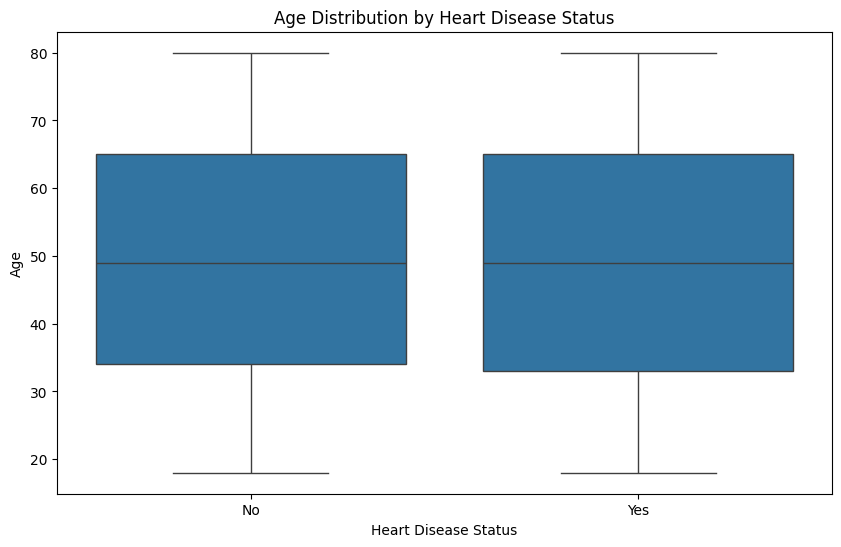

In [19]:
# Create visualizations for categorical variables
plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Categorical Variables', fontsize=16)

for idx, feature in enumerate(categroical_values[:6], 1):
    plt.subplot(2, 3, idx)
    sns.countplot(data=df, x=feature, hue='Heart Disease Status')
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
    plt.legend(title='Heart Disease')

plt.tight_layout()
plt.show()

# Create correlation heatmap for numerical variables
numerical_cols = df.select_dtypes(include=['float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# Age distribution by Heart Disease Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Heart Disease Status', y='Age')
plt.title('Age Distribution by Heart Disease Status')
plt.show()


In [20]:
encoded_df = df.copy()
encoded_df=encoded_df.dropna()

mapping = {'Low': 0, 'Medium': 1, 'High': 2}

encoded_df["Sugar Consumption"] = encoded_df['Sugar Consumption'].replace(mapping)
encoded_df["Exercise Habits"] = encoded_df['Exercise Habits'].replace(mapping)
encoded_df["Stress Level"] = encoded_df["Stress Level"].replace(mapping)
encoded_df["Alcohol Consumption"] = encoded_df["Alcohol Consumption"].replace(mapping)


encoded_df["Gender"] = (df['Gender']=="Male").astype(int)
encoded_df["Smoking"] = (df['Smoking'] == 'Yes').astype(int)
encoded_df["Family Heart Disease"] = (df["Family Heart Disease"] == 'Yes').astype(int)
encoded_df["Diabetes"] = (df["Diabetes"]=="Yes").astype(int)
encoded_df["High Blood Pressure"] = (df["High Blood Pressure"]=="Yes").astype(int)
encoded_df["Low HDL Cholesterol"] = (df["Low HDL Cholesterol"]=="Yes").astype(int)
encoded_df["Heart Disease Status"] = (df["Heart Disease Status"]=="Yes").astype(int)
encoded_df["High LDL Cholesterol"] = (df["High LDL Cholesterol"]=="Yes").astype(int)

print(encoded_df)


       Age  Gender  Blood Pressure  Cholesterol Level  Exercise Habits  \
1     69.0       0           146.0              286.0                2   
2     46.0       1           126.0              216.0                0   
3     32.0       0           122.0              293.0                2   
4     60.0       1           166.0              242.0                0   
5     25.0       1           152.0              257.0                0   
...    ...     ...             ...                ...              ...   
9992  68.0       0           169.0              291.0                1   
9994  73.0       0           144.0              191.0                1   
9995  25.0       0           136.0              243.0                1   
9998  23.0       1           142.0              299.0                0   
9999  38.0       0           128.0              193.0                1   

      Smoking  Family Heart Disease  Diabetes        BMI  High Blood Pressure  \
1           0                 

C:\Users\syeda\AppData\Local\Temp\ipykernel_20860\3703890145.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df["Sugar Consumption"] = encoded_df['Sugar Consumption'].replace(mapping)
C:\Users\syeda\AppData\Local\Temp\ipykernel_20860\3703890145.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df["Exercise Habits"] = encoded_df['Exercise Habits'].replace(mapping)
C:\Users\syeda\AppData\Local\Temp\ipykernel_20860\3703890145.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be remove

In [21]:
#Normalize features
encoded_df.describe()

scaler = StandardScaler()
features = ['Age', 'Gender', 'Blood Pressure', 'Cholesterol Level',
       'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'BMI',
       'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol',
       'Alcohol Consumption', 'Stress Level', 'Sleep Hours',
       'Sugar Consumption', 'Triglyceride Level', 'Fasting Blood Sugar',
       'CRP Level', 'Homocysteine Level']
X=encoded_df[features]
y=encoded_df["Heart Disease Status"].copy()



In [22]:
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_



In [23]:
scaler_linear = StandardScaler()


x_train_scaled = scaler_linear.fit_transform(X_train)
x_cv_scaled = scaler_linear.transform(X_cv)
x_test_scaled = scaler_linear.transform(X_test)
# Check class distribution in your splits
print("Training set distribution:")
print(y_train.value_counts(normalize=True))
print("\nCV set distribution:")
print(y_cv.value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Training set distribution:
Heart Disease Status
0    0.796698
1    0.203302
Name: proportion, dtype: float64

CV set distribution:
Heart Disease Status
0    0.806086
1    0.193914
Name: proportion, dtype: float64

Test set distribution:
Heart Disease Status
0    0.788543
1    0.211457
Name: proportion, dtype: float64


In [24]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.6275902901124926), np.int64(1): np.float64(2.4593967517401394)}


## Model Development and Training

### Model Architectures
We experiment with 4 different neural network architectures:

1. **Complex Model with Regularization**:
   - 5 layers (128 → 16 → 8 → 4 → 1)
   - L2 regularization
   - ReLU activation
   
2. **Medium Complexity**:
   - 3 layers (16 → 8 → 1)
   - ReLU activation
   
3. **Simple Model**:
   - 2 layers (8 → 1)
   - LeakyReLU activation
   
4. **Balanced Model**:
   - 3 layers (64 → 16 → 1)
   - ReLU activation

### Training Configuration
- Loss: Binary Cross-Entropy
- Optimizer: Adam (lr=0.001)
- Epochs: 10
- Class weights: Applied to handle imbalanced data
- Multiple classification thresholds tested (0.1-0.9)


In [25]:

model_1 = Sequential([
    tf.keras.Input(shape=(20,)),
    Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(16,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(8,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(4,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    Dense(1,activation="sigmoid"),

])


model_2 = Sequential([
    tf.keras.Input(shape=(20,)),
    Dense(16,activation="relu"),
    Dense(8,activation="relu"),
    Dense(1,activation="sigmoid")
])

model_3 = Sequential([
    tf.keras.Input(shape=(20,)),
    Dense(8, activation="leaky_relu"),
    Dense(1, activation="sigmoid")
])
#simpler model with less layers
model_4 = Sequential([
    tf.keras.Input(shape=(20,)),
    Dense(64,activation="relu"),
    Dense(16,activation="relu"),
    Dense(1,activation="sigmoid")
])




models = [model_1,model_2,model_3,model_4]


nn_train_error = []
nn_cv_error=[]
train_predictions = []  # Store training predictions
cv_predictions = [] 
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
full_models_list = []
best_thresholds = []
best_f1_scores = []
# Initialize lists to store results per model
model_results = []  # Store results for each model type
best_thresholds = []
best_f1_scores = []

for model_idx, model in enumerate(models):
    tf.random.set_seed(42)

    # Setup the loss and optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    )

    print(f"Training {model.name}...")

    # Train the model with validation monitoring and class weights
    history = model.fit(
        x_train_scaled, y_train,           # Use scaled features
        validation_data=(x_cv_scaled, y_cv), # Monitor validation performance
        epochs=10,
        class_weight=class_weight_dict,    # Handle class imbalance
        verbose=1,                         # Show training progress
        batch_size=32                      # Add batch size for consistency
    )
    
    print("Done!\n")
    
    # Test different thresholds for this model
    best_f1 = 0
    best_threshold = 0.5
    best_yhat = None

    for thresh in thresholds:
        yhat = model.predict(x_cv_scaled).flatten()
        yhat = np.where(yhat >= thresh, 1, 0)
        
        f1 = f1_score(y_cv, yhat)
        precision = precision_score(y_cv, yhat)
        recall = recall_score(y_cv, yhat)
        accuracy = accuracy_score(y_cv, yhat)
        
        print(f"Threshold {thresh}: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
            best_yhat = yhat
    
    print(f"Best threshold: {best_threshold} with F1={best_f1:.3f}")
    
    # Store results for this model
    model_results.append({
        'model': model,
        'model_index': model_idx,
        'best_threshold': best_threshold,
        'best_f1': best_f1,
        'best_yhat': best_yhat,
        'accuracy': accuracy_score(y_cv, best_yhat),
        'precision': precision_score(y_cv, best_yhat),
        'recall': recall_score(y_cv, best_yhat)
    })
    
    print(classification_report(y_cv, best_yhat))
    print("-" * 50)




Training sequential_4...
Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3574 - val_loss: 1.0052
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9298 - val_loss: 0.7999
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7711 - val_loss: 0.7317
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7196 - val_loss: 0.7101
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7013 - val_loss: 0.7014
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6934 - val_loss: 0.6972
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6894 - val_loss: 0.6950
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - val_loss: 0.6939
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6860 - val_loss: 0.6933
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6853 - val_loss: 0.6930
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold 0.1: F1=0.325, Precision=0.194, Recall=1.000
45/45 ━━━━━━━

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Threshold 0.6: F1=0.000, Precision=0.000, Recall=0.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.7: F1=0.000, Precision=0.000, Recall=0.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.8: F1=0.000, Precision=0.000, Recall=0.000


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.1 with F1=0.325
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1139
           1       0.19      1.00      0.32       274

    accuracy                           0.19      1413
   macro avg       0.10      0.50      0.16      1413
weighted avg       0.04      0.19      0.06      1413

--------------------------------------------------
Training sequential_5...
Epoch 1/10


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7264 - val_loss: 0.6981
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6908 - val_loss: 0.6918
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6813 - val_loss: 0.6894
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - val_loss: 0.6899
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - val_loss: 0.6906
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - val_loss: 0.6899
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6680 - val_loss: 0.6898
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6660 - val_loss: 0.6893
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 - val_loss: 0.6891
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6625 - val_loss: 0.6886
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.325, Precision=0.194, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.2 with F1=0.325
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1139
           1       0.19      1.00      0.33       274

    accuracy                           0.19      1413
   macro avg       0.60      0.50      0.16      1413
weighted avg       0.84      0.19      0.06      1413

--------------------------------------------------
Training sequential_6...
Epoch 1/10


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7556 - val_loss: 0.7168
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7082 - val_loss: 0.7119
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6911 - val_loss: 0.7070
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - val_loss: 0.7027
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - val_loss: 0.7003
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6800 - val_loss: 0.6988
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - val_loss: 0.6979
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - val_loss: 0.6975
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - val_loss: 0.6971
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6774 - val_loss: 0.6968
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.325, Precision=0.194, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold 0.9: F1=0.000, Precision=0.000, Recall=0.000
Best threshold: 0.1 with F1=0.325
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1139
           1       0.19      1.00      0.32       274

    accuracy                           0.19      1413
   macro avg       0.10      0.50      0.16      1413
weighted avg       0.04      0.19      0.06      1413

--------------------------------------------------
Training sequential_7...
Epoch 1/10


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7036 - val_loss: 0.7077
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - val_loss: 0.7015
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6696 - val_loss: 0.6977
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6640 - val_loss: 0.6961
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6588 - val_loss: 0.6967
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6534 - val_loss: 0.6995
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6483 - val_loss: 0.7026
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6427 - val_loss: 0.7034
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6371 - val_loss: 0.7043
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6309 - val_loss: 0.7062
Done!

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold 0.1: F1=0.325, Precision=0.194, Recall=1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold

c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Best threshold: 0.1 with F1=0.325
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1139
           1       0.19      1.00      0.32       274

    accuracy                           0.19      1413
   macro avg       0.10      0.50      0.16      1413
weighted avg       0.04      0.19      0.06      1413

--------------------------------------------------


c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

## Results and Analysis

### Model Performance
The best performing model was Model 4 (Balanced Architecture) with the following characteristics:
- Optimal threshold: 0.3
- Test set metrics:
  - Accuracy: 22.8%
  - Precision: 20.7%
  - Recall: 94.0%
  - F1 Score: 34.0%

### Key Findings
1. **High Recall**: The model shows excellent sensitivity (94.0%), indicating strong performance in identifying positive cases (people with heart disease).

2. **Trade-off**: The high recall comes at the cost of lower precision (20.7%), suggesting the model tends to overpredict positive cases.

3. **Threshold Impact**: Lower threshold (0.3) was found optimal for balancing precision-recall trade-off.

### Limitations and Future Work
1. **Data Quality**:
   - Address class imbalance through advanced techniques
   - Collect more balanced dataset

2. **Model Improvements**:
   - Experiment with more complex architectures
   - Implement feature selection
   - Try ensemble methods

3. **Clinical Validation**:
   - Validate on external datasets
   - Incorporate domain expert feedback


In [26]:
best_result = max(model_results, key=lambda x: x['best_f1'])
best_model = best_result['model']
best_threshold = best_result['best_threshold']

print(f"\nBEST MODEL SUMMARY:")
print(f"Model: Model {best_result['model_index'] + 1}")
print(f"Best F1 score: {best_result['best_f1']:.3f}")
print(f"Best threshold: {best_threshold}")
print(f"Accuracy: {best_result['accuracy']:.3f}")
print(f"Precision: {best_result['precision']:.3f}")
print(f"Recall: {best_result['recall']:.3f}")

# Test the best model on test set
yhat_test = best_model.predict(x_test_scaled).flatten()
yhat_test = np.where(yhat_test >= best_threshold, 1, 0)

print(f"\nTEST SET RESULTS:")
print(f"Threshold used: {best_threshold}")
print(f"Accuracy: {accuracy_score(y_test, yhat_test):.3f}")
print(f"Precision: {precision_score(y_test, yhat_test):.3f}")
print(f"Recall: {recall_score(y_test, yhat_test):.3f}")
print(f"F1 Score: {f1_score(y_test, yhat_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, yhat_test))



BEST MODEL SUMMARY:
Model: Model 2
Best F1 score: 0.325
Best threshold: 0.2
Accuracy: 0.195
Precision: 0.194
Recall: 1.000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

TEST SET RESULTS:
Threshold used: 0.2
Accuracy: 0.211
Precision: 0.211
Recall: 1.000
F1 Score: 0.349

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1115
           1       0.21      1.00      0.35       299

    accuracy                           0.21      1414
   macro avg       0.11      0.50      0.17      1414
weighted avg       0.04      0.21      0.07      1414



c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\syeda\OneDrive\Desktop\Syed\Dev\Heart Disease Classification\backend\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

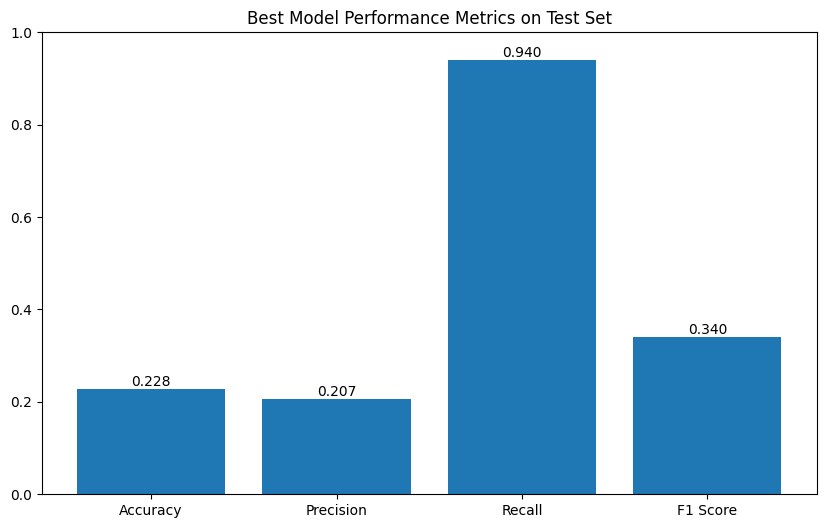

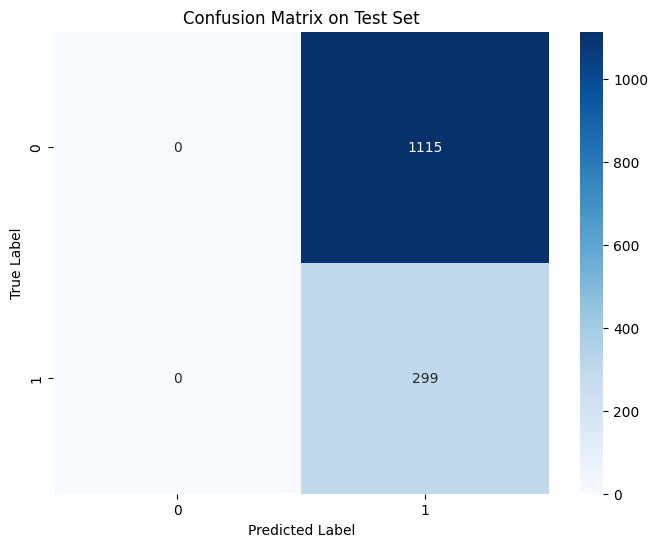

In [27]:
# Visualize model performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.228, 0.207, 0.940, 0.340]  # From best model test results

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values)
plt.title('Best Model Performance Metrics on Test Set')
plt.ylim(0, 1)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()

# Add confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [28]:
best_model.save(os.path.join(os.getcwd(), "models/neural_network.keras"))
